In [1]:
import numpy as np
import random
import pickle
from IPython.display import clear_output

# import gym
# from gym.envs.box2d.lunar_lander import LunarLander
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim import RMSprop

In [2]:
class ReplayBuffer:
  def __init__(self, buffer_size, batch_size, seed = 0):
    self.buffer = []
    self.max_size = buffer_size
    self.batch_size = batch_size
    self.random_generator = np.random.RandomState(seed)

  def append(self, state, action, reward, terminal, next_state):
    if(len(self.buffer) == self.max_size):
      del self.buffer[0]

    self.buffer.append([state, action, reward, terminal, next_state])

  def sample(self):
    batch = random.sample(self.buffer, self.batch_size)

    state, action, reward, terminal, next_state = map(np.stack, zip(*batch))
    
    return state, action, reward, terminal, next_state

  def get_buffer_size(self):
    return len(self.buffer)

In [3]:
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)

# %%
class QNetwork(nn.Module):
    def __init__(self, input_channels, num_actions):
        super(QNetwork, self).__init__()

        self.conv = nn.Conv2d(input_channels, 16, kernel_size =3, stride =1)

        def size_linear_unit(size, kernel_size = 3, stride = 1):
            return (size - (kernel_size - 1) - 1)//stride + 1

        num_hidden_unit = size_linear_unit(10) * size_linear_unit(10) * 16

        self.fc_hidden1 = nn.Linear(num_hidden_unit, 128)

        self.output = nn.Linear(128,num_actions)

        self.apply(weights_init_)

    def forward(self, state):
        state = state.permute(0,3,1,2)
        
        x1 = F.relu(self.conv(state))
        x1 = F.relu(self.fc_hidden1( x1.reshape(x1.size(0), -1) ))
        x1 = self.output(x1)
        
        return x1

In [6]:
GRAD_MOMENTUM = 0.95
MIN_SQUARED_GRAD = 0.01

class Agent(object):
    def __init__(self, observation_space = 10, channels = 4, action_space = 4, lr = 1e-3, 
                 gamma = 0.99, epsilon = 0.91, annealing_coefficient =  0.9999, tau = 1e-3, seed = 1):
        
        self.rng = np.random.default_rng(seed)

        self.observation_space = observation_space #In minitar it's always 10
        self.channels = channels
        self.actions = action_space
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.tau = tau
        self.annealing_coefficient = annealing_coefficient


        self.device = "cuda:1" if torch.cuda.is_available() else "cpu"
        
        self.Q_Net = QNetwork(self.channels, self.actions).to(self.device)
        
        self.target_Q_Net = QNetwork(self.channels, self.actions).to(self.device)
        
        for target_param, param in zip( self.target_Q_Net.parameters(), self.Q_Net.parameters()):
            target_param.data.copy_( param.data * self.tau + (1-self.tau) * target_param.data)
        
        self.joint_optimizer = RMSprop(self.Q_Net.parameters(), lr=self.lr, alpha=GRAD_MOMENTUM, centered=True, eps=MIN_SQUARED_GRAD)

        
        self.batch_size = 32
        self.buffer = ReplayBuffer(100000, self.batch_size)

    def take_action(self, state):
 
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0)
        
        actions_pred = self.Q_Net.forward(state)

        actions_pred = actions_pred.detach().cpu().numpy()[0]
        
        softmax_q = np.exp(actions_pred - np.max(actions_pred))/np.sum(np.exp(actions_pred - np.max(actions_pred)))
        
        
        if self.epsilon > self.rng.random():
            action = self.rng.choice(self.actions)
            #aindex = np.where(action == self.actions)[0][0]
            
            return action, softmax_q[action], softmax_q
        else:
            action = np.argmax(actions_pred)

            return action, softmax_q[action], softmax_q
        
    def update(self):
        state, action, reward, terminal, next_state = self.buffer.sample()


        state_batch = torch.FloatTensor(state).to(self.device)
        next_state_batch = torch.FloatTensor(next_state).to(self.device)
        action_batch = torch.FloatTensor(action).to(self.device).long().unsqueeze(1)
        reward_batch = torch.FloatTensor(reward).to(self.device).unsqueeze(1)
        terminal = torch.FloatTensor(terminal).to(self.device).unsqueeze(1)
       
        
        qs = self.Q_Net.forward(state_batch)
        q = torch.gather(qs, 1, action_batch)

        q_online_target = self.Q_Net.forward(next_state_batch)
        q_online_target_best_actions = torch.argmax(q_online_target,1,True)

        q_target = self.target_Q_Net.forward(next_state_batch)
        next_q = torch.gather(q_target, 1, q_online_target_best_actions)
        
        
        # next_qs = self.target_Q_Net.forward(next_state_batch)

        # next_q = torch.max(next_qs, 1, True)[0]

        td = reward_batch + self.gamma * (1 - terminal) * next_q - q
        #target = reward_batch + self.gamma * (1 - terminal) * next_q
        #qf_loss = F.mse_loss(q, target)
        qf_loss = (td ** 2).mean()

        self.joint_optimizer.zero_grad()
        qf_loss.backward()
        self.joint_optimizer.step()


        for target_param, param in zip( self.target_Q_Net.parameters(), self.Q_Net.parameters()):
            target_param.data.copy_( param.data * self.tau + (1-self.tau) * target_param.data)

        if self.epsilon > 0.1:
            self.epsilon *= self.annealing_coefficient


    def set_RDG_seed(self, seed):
        self.rng = np.random.default_rng(seed)


In [7]:
env = gym.make("MinAtar/Asterix-v1")

FRAMES = 3000000

returns_across_seeds = []

annealing_rate = (0.1/0.91)**(1/100000)

for seed in range(1):

    agent = Agent(action_space = env.action_space.n, lr = 3e-4, annealing_coefficient=annealing_rate, tau=1e-3, seed=seed)
        
    return_per_episode = []

    frame = 0
    
    while frame < FRAMES: #episodes

        state = env.reset()[0]
        G = 0
        done = 0

        while not done and frame < FRAMES:

            action, q, allQ = agent.take_action(state)

            new_state, reward, done, _, _ = env.step(action)

            G += reward

            agent.buffer.append(state, action, reward, done, new_state)

            if (agent.buffer.get_buffer_size() > agent.buffer.batch_size):
                agent.update()
            
            state = new_state

            frame+=1
        
        return_per_episode.append(G)

    returns_across_seeds.append(return_per_episode)


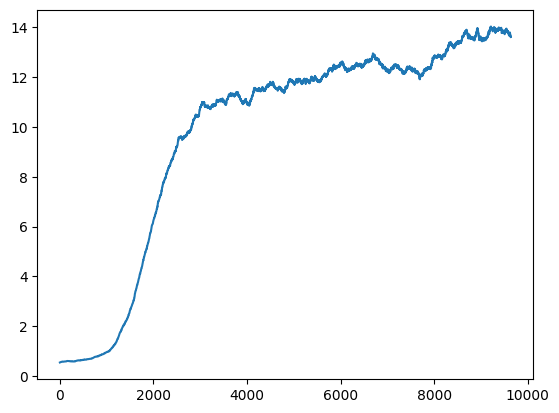

In [9]:

kernel_size = 1000
kernel = np.ones(kernel_size) / kernel_size

all_rewards = []
for data in returns_across_seeds:
    rewards = np.convolve(data, kernel)
    all_rewards.append(rewards[kernel_size:-kernel_size])

# all_traps = []
# for data, step in zip(crashes_across_seeds):
#     #steps_cum_sum = np.cumsum(np.ones(len(data)))
#     crashes = np.cumsum(data)
#     all_traps.append(crashes)


data = np.convolve(return_per_episode, kernel)
data = data[kernel_size:-kernel_size]


x = np.arange(len(data))
y = data

plt.plot(x,y)